### Intro and Data

かめ @usdatascientist さんのUdemy講座「Python」「Docker」で環境構築

Pythonを使った機械学習チュートリアルシリーズのリグレッションセクションへようこそ。
この時点ですでにScikit-Learnがインストールされているはずです。
そうでない場合は、Pandasとmatplotlibと一緒に入手してください。

もしあなたがActivePythonのような科学的なPythonのコンパイル済みディストリビューションをスポンサーから提供されているならば、すでにnumpy, scipy, scikit-learn, matplotlib, pandasがインストールされているはずです。
そうでない場合は、そうしてください。

チュートリアル全体のインポートに加えて、ここでは Quandl を使用しています。

run -v ~/Documents/work:/work -p 8888:8888 --name my-env datascientistus/ds-python-env

dockre run -v pcワークdir:dockerワークdir -p pcポート番号:dockerポート番号 --name 名前　イメージファイル名

docker restart
docker images
docker ps -a
docker rmi イメージ名
docker rm コンテナ名
docker stop コンテナ名
docker exec コンテナ名前 /bin/bash

conda install -c anaconda quandl

はじめに、機械学習でそれを使うという意味での回帰とは何でしょうか？
目標は、連続的なデータを取り、データに最もフィットする方程式を見つけ、特定の値を予測できるようにすることです。
単純な線形回帰では、単に最適な線を作成することでこれを行うだけです。

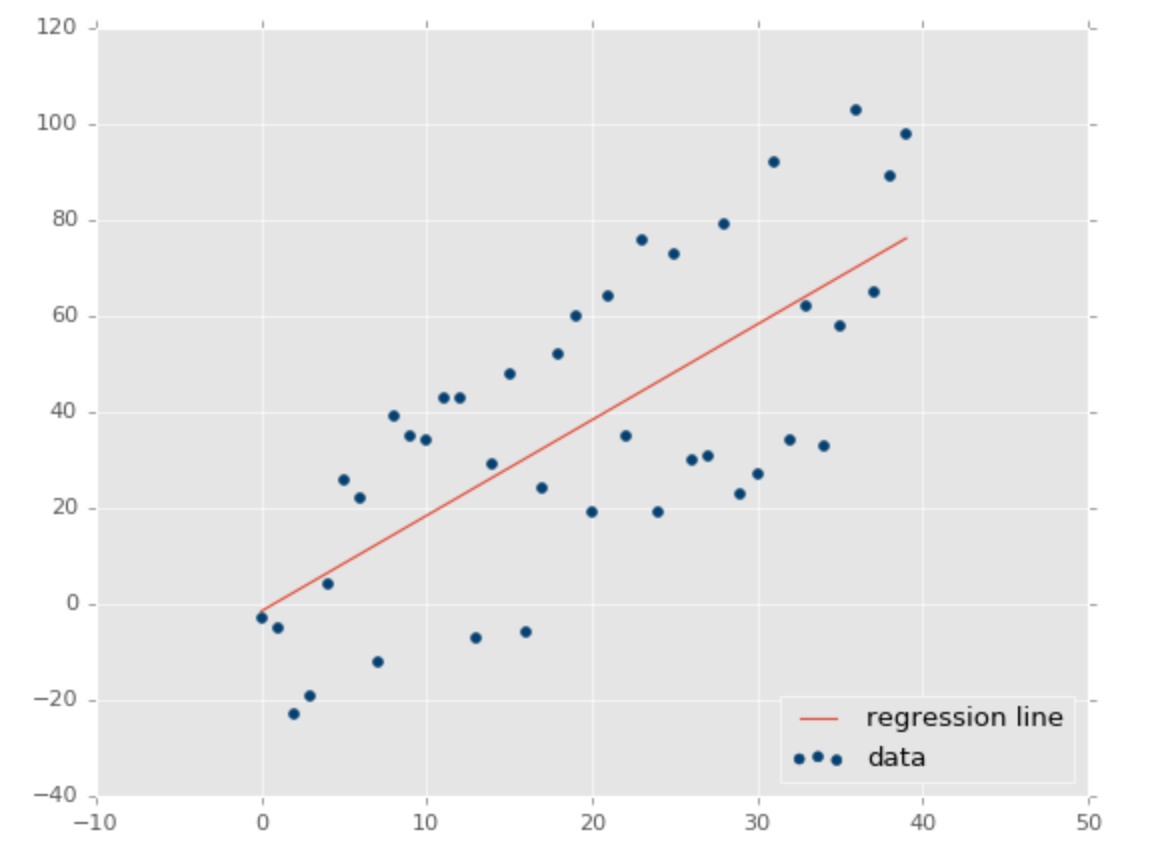

ここから、我々は、その線の方程式を使用して、将来に予測することができます。

回帰を使ってよく使われるのは、株価を予測することです。これは、時間的な価格の流動性を考慮し、連続的なデータセットを使って将来の次の流動的な価格を予測しようとしているために行われます。

回帰は教師付き機械学習の一形態であり、科学者が機械に特徴を示し、何度も何度も何が正解であるかを示すことで、機械を教えるというものです。
一旦マシンが学習されると、科学者は通常、目に見えないデータでマシンを「テスト」します。
マシンの答えは既知の答えと比較され、マシンの精度が測定されます。
精度が十分に高ければ、科学者は実際の世界でアルゴリズムを採用することを検討するかもしれません。

回帰は株価でよく使われているので、我々は例を挙げてそこから始めることができます。
まず、データが必要です。
データは簡単に手に入ることもあれば、以前のチュートリアルシリーズで行った、投資のための機械学習のように、外に出てデータを集めなければならないこともあります。
私たちの場合は、少なくともQuandlの簡単な株価と出来高情報から始めることができます。
まず、Alphabet（以前はGoogle）の株価を把握しているデータから始めましょう。

In [ ]:
import pandas as pd
import quandl

df = quandl.get("WIKI/GOOGL")

print(df.head())

素晴らしい、良いスタートを切った、データはあるが、少し多すぎるかもしれない。イントロを参照するために、機械学習のカテゴリーには、処理する入力の量を減らすことを目的としたものがあります。
私たちの場合、かなりの数の列があり、多くは冗長で、2つの列は実際には変化がありません。
通常のカラムと調整済みのカラムの両方を持つことは冗長であることに同意できるでしょう。
調整済みのカラムは最も理想的なカラムです。
通常の列はその日の価格ですが、株式には株式分割と呼ばれるものがあり、1株が突然2株のようになり、1株の価値は半減しますが、会社の価値は半減していません。
調整済みカラムは、時間の経過とともに株式分割を調整したもので、分析を行う上でより信頼性の高いものとなっています。

というわけで、先に行ってオリジナルのデータフレームを少しペアリングしてみましょう。

In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

print(df.head())

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume
Date                                                                
2004-08-19  50.159839  52.191109  48.128568   50.322842   44659000.0
2004-08-20  50.661387  54.708881  50.405597   54.322689   22834300.0
2004-08-23  55.551482  56.915693  54.693835   54.869377   18256100.0
2004-08-24  55.792225  55.972783  51.945350   52.597363   15247300.0
2004-08-25  52.542193  54.167209  52.100830   53.164113    9188600.0


これで、調整済みの列とボリュームの列ができました。
ここでいくつかの重要なポイントがあります。
多くの人が機械学習について話したり聞いたりするのは、あたかも機械学習が何もないところから何らかの形で価値を生み出す闇の芸術であるかのようです。
機械学習は、価値があれば強調することができますが、実際に価値がなければなりません。
意味のあるデータが必要です。
では、どうやって意味のあるデータがあるかどうかを知るのでしょうか？私の一番の提案は、単にあなたの頭脳を使うことです。
考えてみてください。過去の価格は将来の価格を示しているでしょうか？そう考える人もいますが、これは時間をかけて証明され続けています。
歴史的なパターンについてはどうでしょうか？これは極端に言えば（機械学習が助けになる）もう少しメリットがありますが、全体的にはかなり弱いです。
過去のパターンと一緒に、時間の経過による価格変化と数量の関係はどうでしょうか？おそらくもう少し良いでしょう。
このように、すでにお分かりのように、データは多ければ多いほど良いというわけではなく、むしろ有用なデータを使いたいのです。それと同時に、生データは時には変換しなければなりません。

高値-底値の％変化でのように、毎日の価格変動を考えてみませんか？
毎日の％変化はどうでしょうか？単純に始値、高値、安値、終値のデータまたは、終値、価格差/価格変動、％変化のデータのどちらが良いと思いますか？
私は後者の方が理想的だと思います。
前者はすべて非常に似たデータポイントです。
後者は前者と同じデータに基づいて作成されていますが、テーブルにははるかに価値のある情報がもたらされます。

このように、あなたが持っているデータのすべてが有用であるとは限らず、機械学習アルゴリズムを介してデータを供給する前に、データをさらに価値のあるものにするために、データにさらなる操作を行う必要がある場合もあります。
次にデータを変換してみましょう。

In [7]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0

print(df.head())

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume    HL_PCT
Date                                                                          
2004-08-19  50.159839  52.191109  48.128568   50.322842   44659000.0  8.072956
2004-08-20  50.661387  54.708881  50.405597   54.322689   22834300.0  7.921706
2004-08-23  55.551482  56.915693  54.693835   54.869377   18256100.0  4.049360
2004-08-24  55.792225  55.972783  51.945350   52.597363   15247300.0  7.657099
2004-08-25  52.542193  54.167209  52.100830   53.164113    9188600.0  3.886792


私は先に進んでこれのビデオ版を録画しましたが、私の賭け金が高値から安値を引いたものであることに気付かなかった。
私は高値-低値をするつもりだったが、低値で割ってしまった。
必要に応じて、自由に修正してください。

これにより、価格変動の大まかな尺度である％スプレッドベースの終値の新しい列が作成されます。
次に、毎日のパーセント変更を行います。

※スプレッドとは、売付価格と買付価格の差

In [8]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open']

次に、新しいデータフレームを次のように定義します。

In [9]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.003250   44659000.0
2004-08-20   54.322689  7.921706    0.072270   22834300.0
2004-08-23   54.869377  4.049360   -0.012279   18256100.0
2004-08-24   52.597363  7.657099   -0.057264   15247300.0
2004-08-25   53.164113  3.886792    0.011837    9188600.0
